### Loading liberary and dataset


In [1]:
library(MASS)
library(randomForest)
library(gbm)
library(e1071)


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Loaded gbm 2.1.8.1



In [2]:
attach(Boston)

## Prepare training and test data 
set.seed(1)
train <- sample(1:nrow(Boston), nrow(Boston) / 2)
boston.test <- Boston[-train, "medv"]
p <- length(Boston) - 1


In [3]:
# MSE <- (\(predict, test) mean((predict - test)**2))
# MSE(yhat.bag, boston.test)


### Bagging



Call:
 randomForest(formula = medv ~ ., data = Boston, mtry = p, ntree = 100,      importance = TRUE, subset = train) 
               Type of random forest: regression
                     Number of trees: 100
No. of variables tried at each split: 13

          Mean of squared residuals: 11.10256
                    % Var explained: 85.56

[1] 23.48538

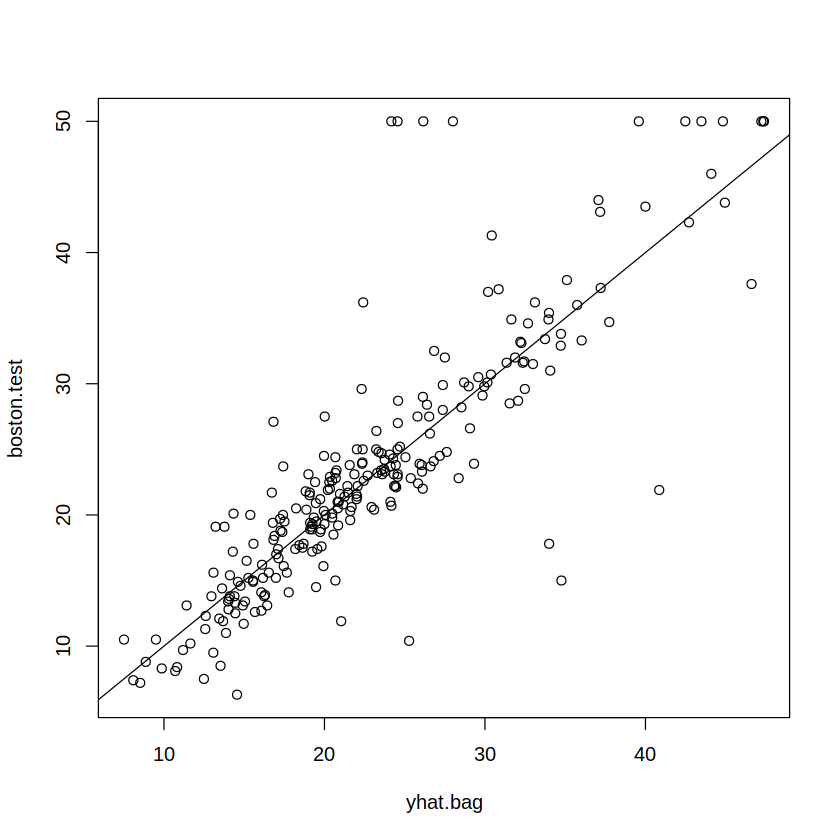

In [4]:
## Bagging: randomforest with mtry=number of Predictors
set.seed(1)
bag.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = p, ntree = 100, importance = TRUE)
bag.boston

## Calculate test MSE
yhat.bag <- predict(bag.boston, newdata = Boston[-train, ])
mean((yhat.bag - boston.test)^2)


## Actual observations of test data and predictions
plot(yhat.bag, boston.test)
abline(0, 1) # line with intercept 0 and slope 1


### Random Forests

In [5]:
## mtry=number of Predictors
set.seed(1)
rf.boston <- randomForest(medv ~ ., data = Boston, subset = train, mtry = 6, ntree = 100, importance = TRUE)
yhat.rf <- predict(rf.boston, newdata = Boston[-train, ])
mean((yhat.rf - boston.test)^2)

[1] 18.90009

### Boosting

,var,rel.inf
,<chr>,<dbl>
rm,rm,43.9919329
lstat,lstat,33.1216941
crim,crim,4.2604167
dis,dis,4.0111090
nox,nox,3.4353017
black,black,2.8267554
age,age,2.6113938
ptratio,ptratio,2.5403035
tax,tax,1.4565654


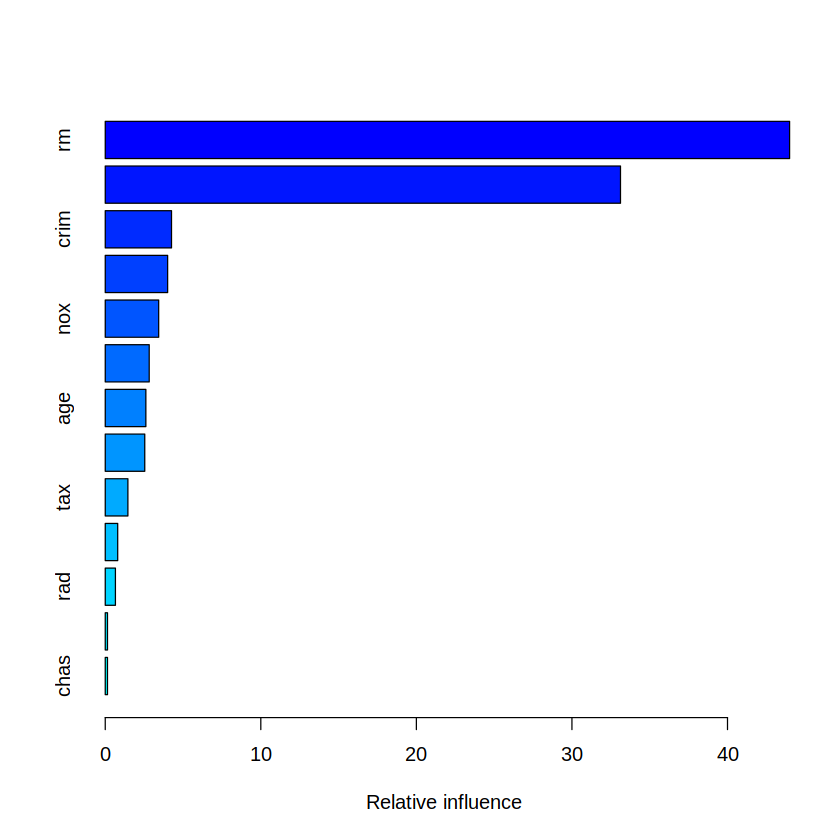

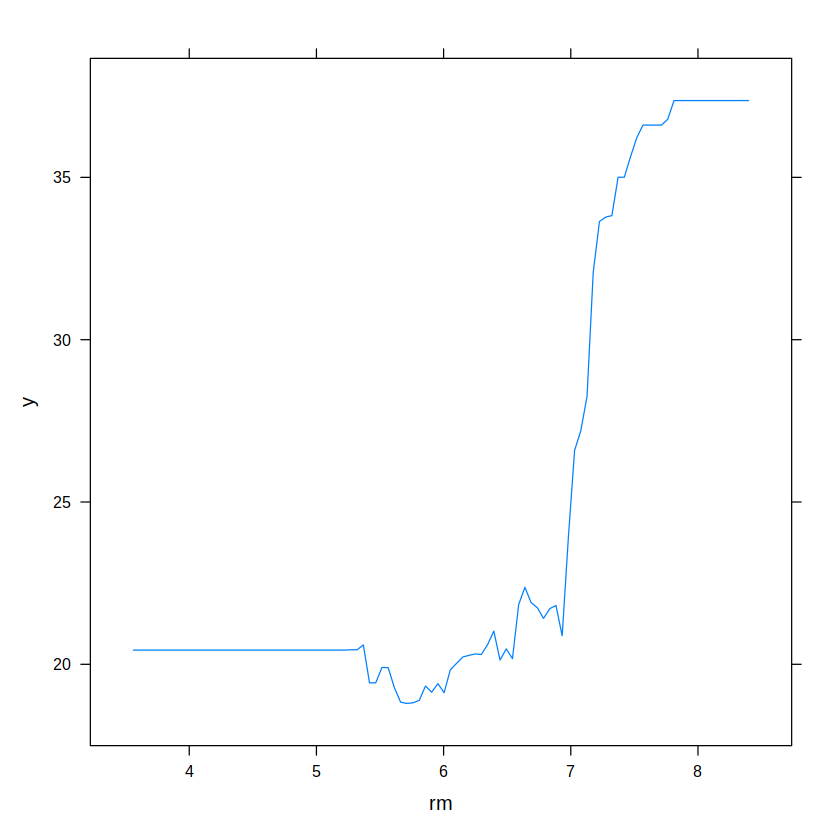

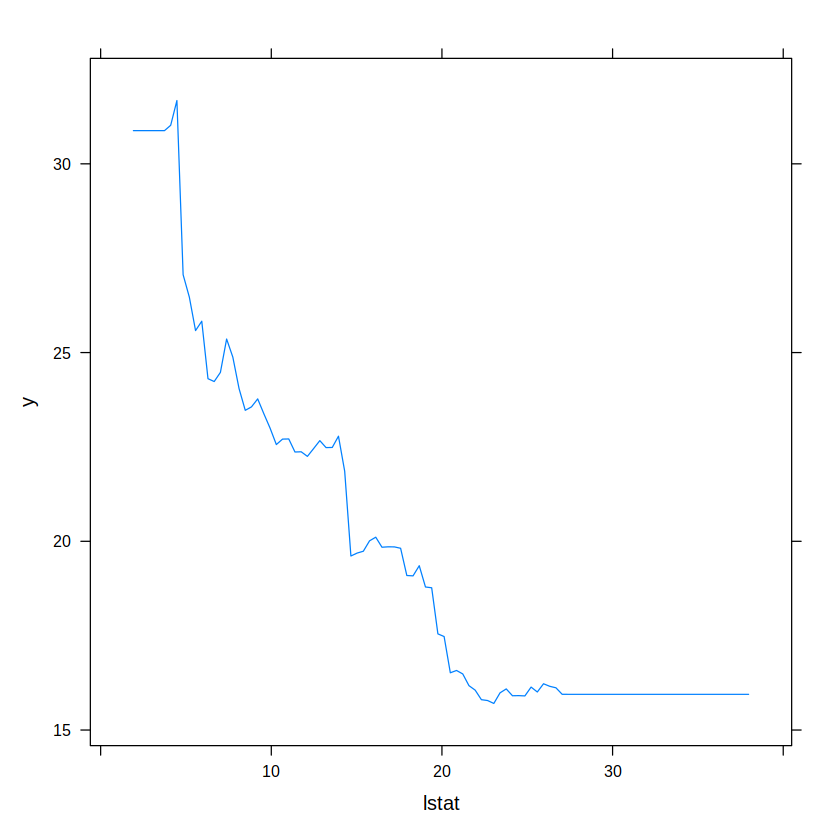

In [6]:
set.seed(1)
boost.boston <- gbm(medv ~ ., data = Boston[train, ], distribution = "gaussian", n.trees = 5000, interaction.depth = 4)

## Regression: distribution="gaussian"
## Classification: distribution="bernoulli"
summary(boost.boston) ## relative influence plot

par(mfrow = c(1, 2))
plot(boost.boston, i = "rm") ## partial dependence plot
plot(boost.boston, i = "lstat")


In [7]:
yhat.boost <- predict(boost.boston, newdata = Boston[-train, ], n.trees = 5000)
mean((yhat.boost - boston.test)^2)


[1] 18.84709

### Support Vector Classifier

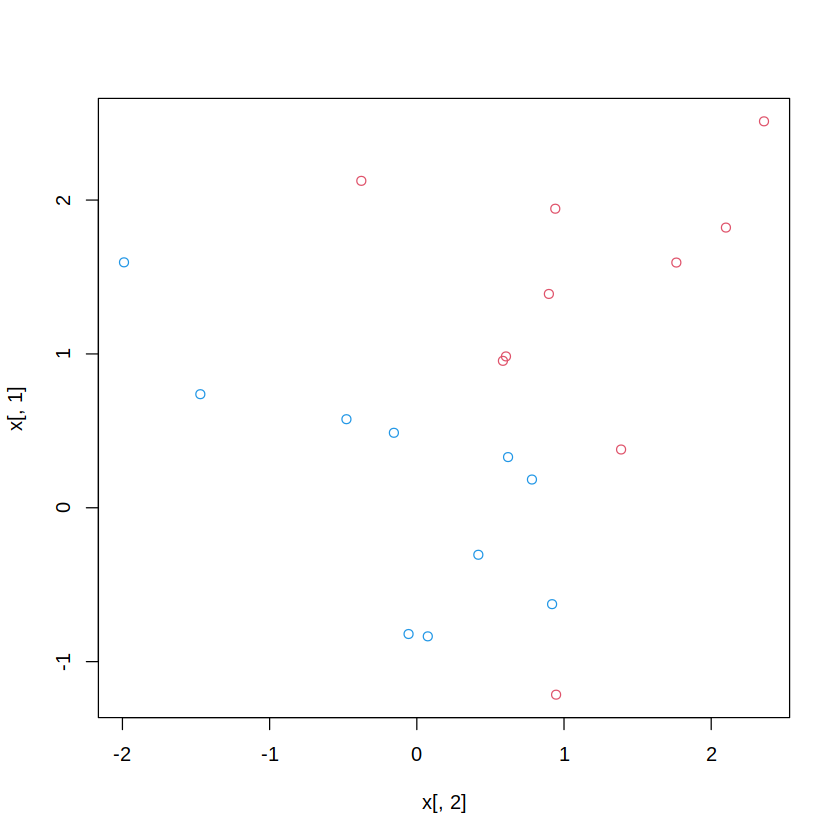

In [8]:
## Generate training data
set.seed(1)
number <- 20
x <- matrix(rnorm(number * 2), ncol = 2)
y <- c(rep(-1, number / 2), rep(1, number / 2))
x[y == 1, ] <- x[y == 1, ] + 1
plot(x[, 2], x[, 1], col = (3 - y)) ## color=2(red), 4(blue) red:1, blue:-1


x.1,x.2,y
<dbl>,<dbl>,<fct>
-0.6264538,0.91897737,-1
0.1836433,0.78213630,-1
-0.8356286,0.07456498,-1
1.5952808,-1.98935170,-1
0.3295078,0.61982575,-1
-0.8204684,-0.05612874,-1
0.4874291,-0.15579551,-1
0.7383247,-1.47075238,-1
0.5757814,-0.47815006,-1


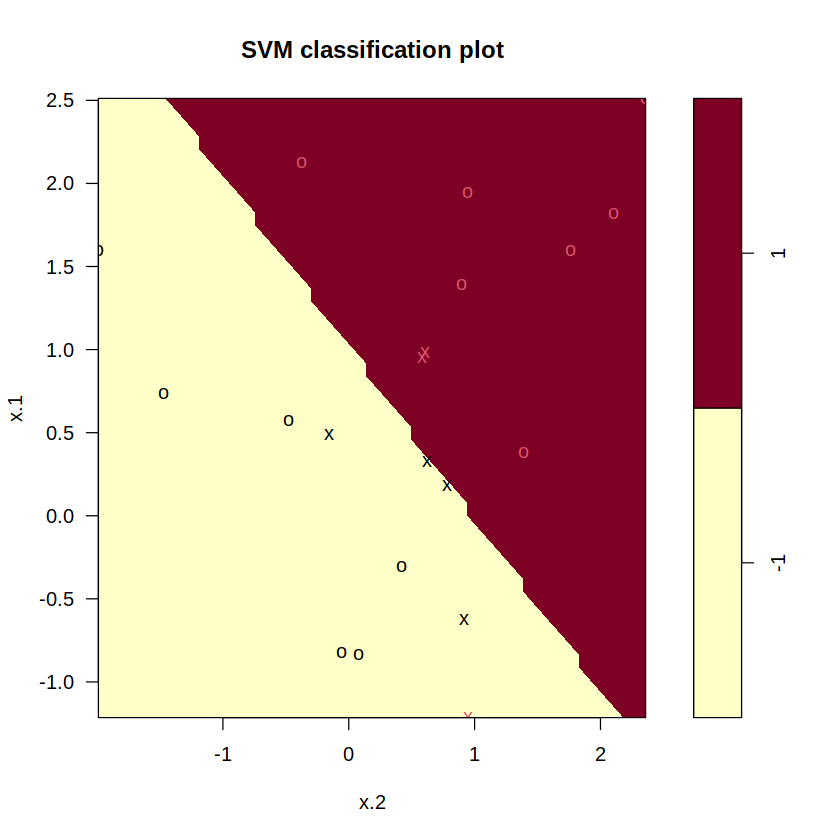

In [9]:
## Fit the support vector classifier
dat <- data.frame(x = x, y = as.factor(y))
dat
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)
## "cost" is similar to tuning parameter C, but with opposite effects: small "cost", wide margin; large "cost", narrow margin

plot(svmfit, dat)


In [10]:
summary(svmfit)
## Find support vectors
svmfit$index



Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 10, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  10 

Number of Support Vectors:  7

 ( 4 3 )


Number of Classes:  2 

Levels: 
 -1 1




[1]  1  2  5  7 14 16 17


Call:
svm(formula = y ~ ., data = dat, kernel = "linear", cost = 0.1, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




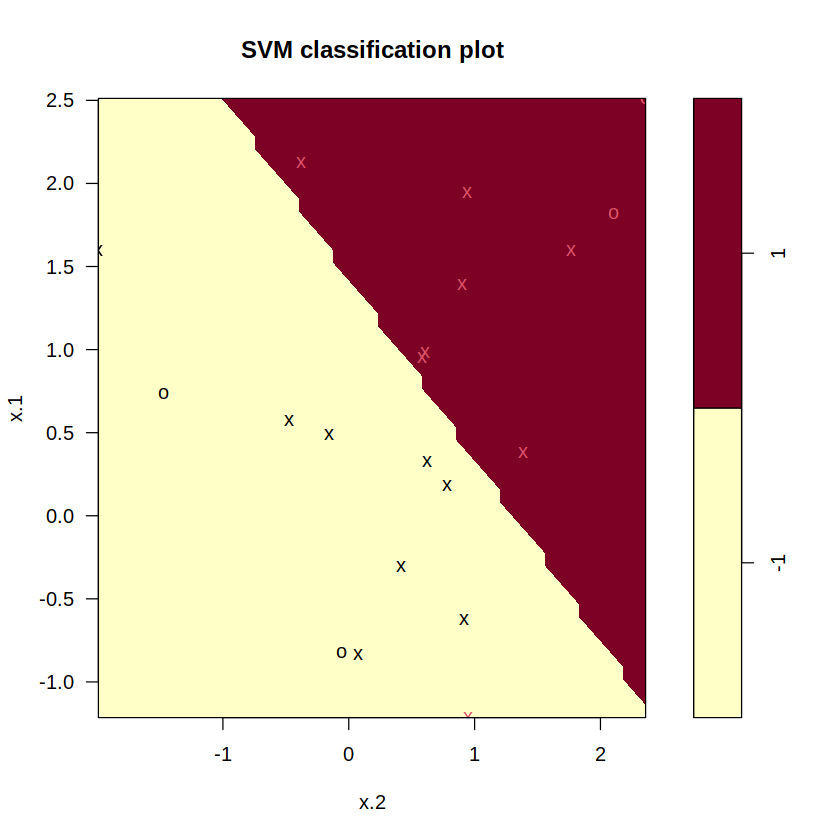

In [11]:
## Use a smaller value for cost
svmfit <- svm(y ~ ., data = dat, kernel = "linear", cost = 0.1, scale = FALSE)
plot(svmfit, dat)
summary(svmfit)


### Cross validation


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost
  0.1

- best performance: 0.05 

- Detailed performance results:
   cost error dispersion
1 1e-03  0.55  0.4377975
2 1e-02  0.55  0.4377975
3 1e-01  0.05  0.1581139
4 1e+00  0.15  0.2415229
5 5e+00  0.15  0.2415229
6 1e+01  0.15  0.2415229
7 1e+02  0.15  0.2415229



Call:
best.tune(METHOD = svm, train.x = y ~ ., data = dat, ranges = list(cost = c(0.001, 
    0.01, 0.1, 1, 5, 10, 100)), kernel = "linear")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  linear 
       cost:  0.1 

Number of Support Vectors:  16

 ( 8 8 )


Number of Classes:  2 

Levels: 
 -1 1




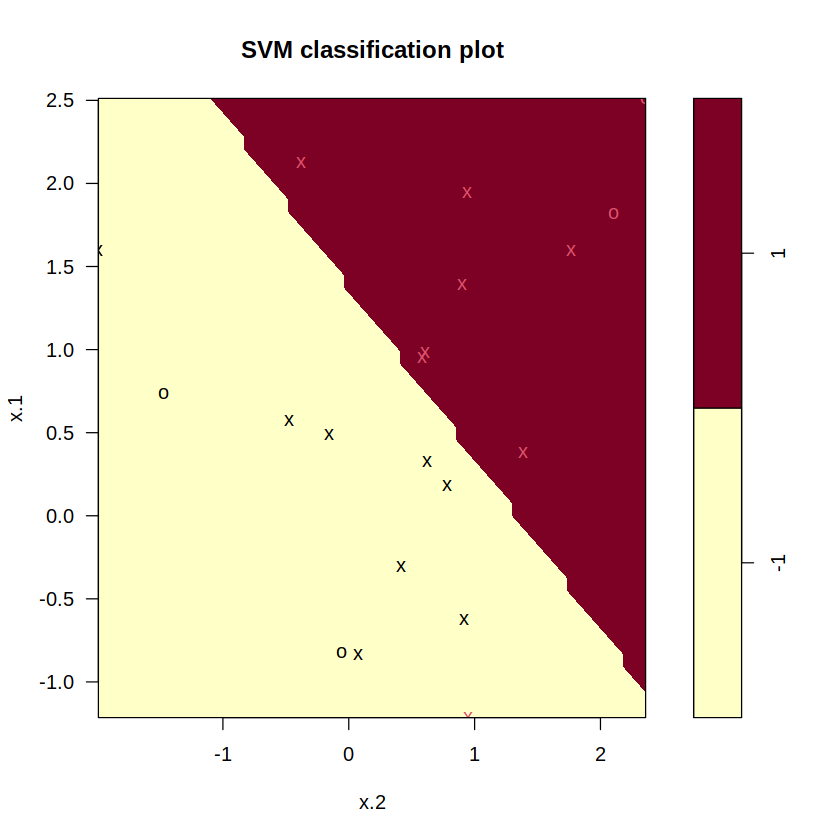

In [12]:
## Use cross validation to find best value for cost
set.seed(1)
tune.out <- tune(svm, y ~ ., data = dat, kernel = "linear", ranges = list(cost = c(0.001, 0.01, 0.1, 1, 5, 10, 100)))
summary(tune.out)

## Best model
bestmod <- tune.out$best.model
summary(bestmod)
plot(bestmod, dat)


In [13]:
## Generate test data
xtest <- matrix(rnorm(20 * 2), ncol = 2)
ytest <- sample(c(-1, 1), 20, rep = TRUE)
xtest[ytest == 1, ] <- xtest[ytest == 1, ] + 1
testdat <- data.frame(x = xtest, y = as.factor(ytest))

## Prediction
ypred <- predict(bestmod, testdat)
table(predict = ypred, truth = testdat$y)


       truth
predict -1 1
     -1  9 1
     1   2 8